In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from random import random
import pandas as pd
from numpy.linalg import inv
import scipy.stats as stats
import time 
import random as rd

# 4. Gibbs Sampler

In [5]:
def sampling_s_ty(sigma_O, mu_s, sigma_s, t):
    A = np.array([[1,-1]])
    sigma_s_ty = inv(inv(sigma_s) + A.T * (1/sigma_O) @ A)
    mu_s_ty = sigma_s_ty @ (inv(sigma_s) @ mu_s + A.T * (1/sigma_O) * t)
    
    return stats.multivariate_normal.rvs(mu_s_ty.reshape(-1), sigma_s_ty)

In [6]:
def sampling_t_sy(y, s_1, s_2, sigma_O):
    loc = s_1 - s_2
    scale = sigma_O
    if y == 1:
        myclip_a = 0
        myclip_b = np.Inf
    elif y == -1:
        myclip_a = -np.Inf
        myclip_b = 0
    
    a, b = (myclip_a - loc) / scale, (myclip_b - loc) / scale
    return stats.truncnorm.rvs(a, b, loc, scale)

In [7]:
def GibbsSampling(initial_point, y, mu_s, sigma_s, sigma_O, num_samples, burn):
    samples_s_1 = []
    samples_s_2 = []
    s_1 = initial_point[0]
    s_2 = initial_point[1]
    for i in range(num_samples):
        t = sampling_t_sy(y, s_1, s_2, sigma_O)
        s_1, s_2 = sampling_s_ty(sigma_O, mu_s, sigma_s, t)
        samples_s_1.append(s_1)
        samples_s_2.append(s_2)
    return samples_s_1[burn:], samples_s_2[burn:]

## 4.1 determine burn in

In [10]:
s0 = [0,0]
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])
t0 = time.time()

mean = []
num_samples = 500
for sample_size in range(0, num_samples, 10):
    vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, sample_size, burn=0)
    mean_s1 = np.mean(vec_s1)
    mean_s2 = np.mean(vec_s2)
    mean.append((mean_s1, mean_s2))
    
mean = np.array(mean)


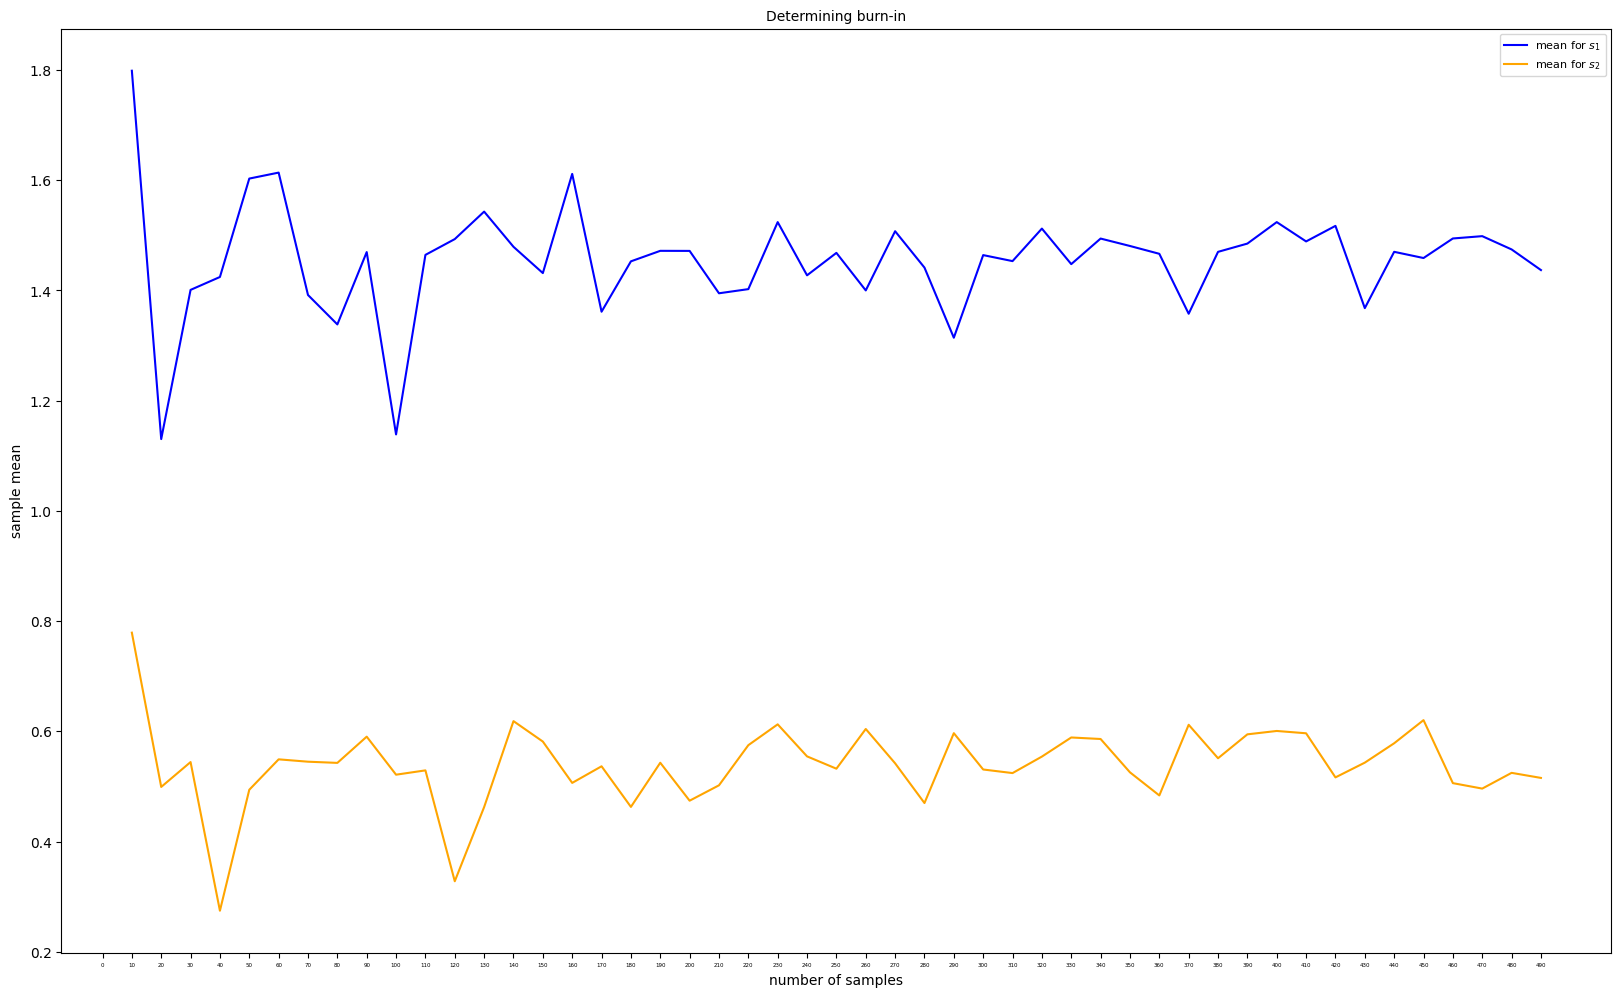

In [11]:
# Plot burn-in
plt.rcParams["figure.figsize"] = (20,12)
plt.title("Determining burn-in", fontsize=10)
x = range(0, num_samples, 10)
plt.plot(x, mean[:, 0], c='b', label=r'mean for $s_1$')
plt.plot(x, mean[:, 1], c='orange', label=r'mean for $s_2$')

plt.legend(fontsize=8)
plt.xlabel("number of samples")
plt.ylabel("sample mean")
x_xticks = range(0, num_samples, 10)
plt.xticks(x_xticks, fontsize=4)
plt.show()


Approximately, according to the graph, we will choose burn-in = 50

## 4.2 Plot the samples of the posterior

1.5282535834727597
0.5859328792321176


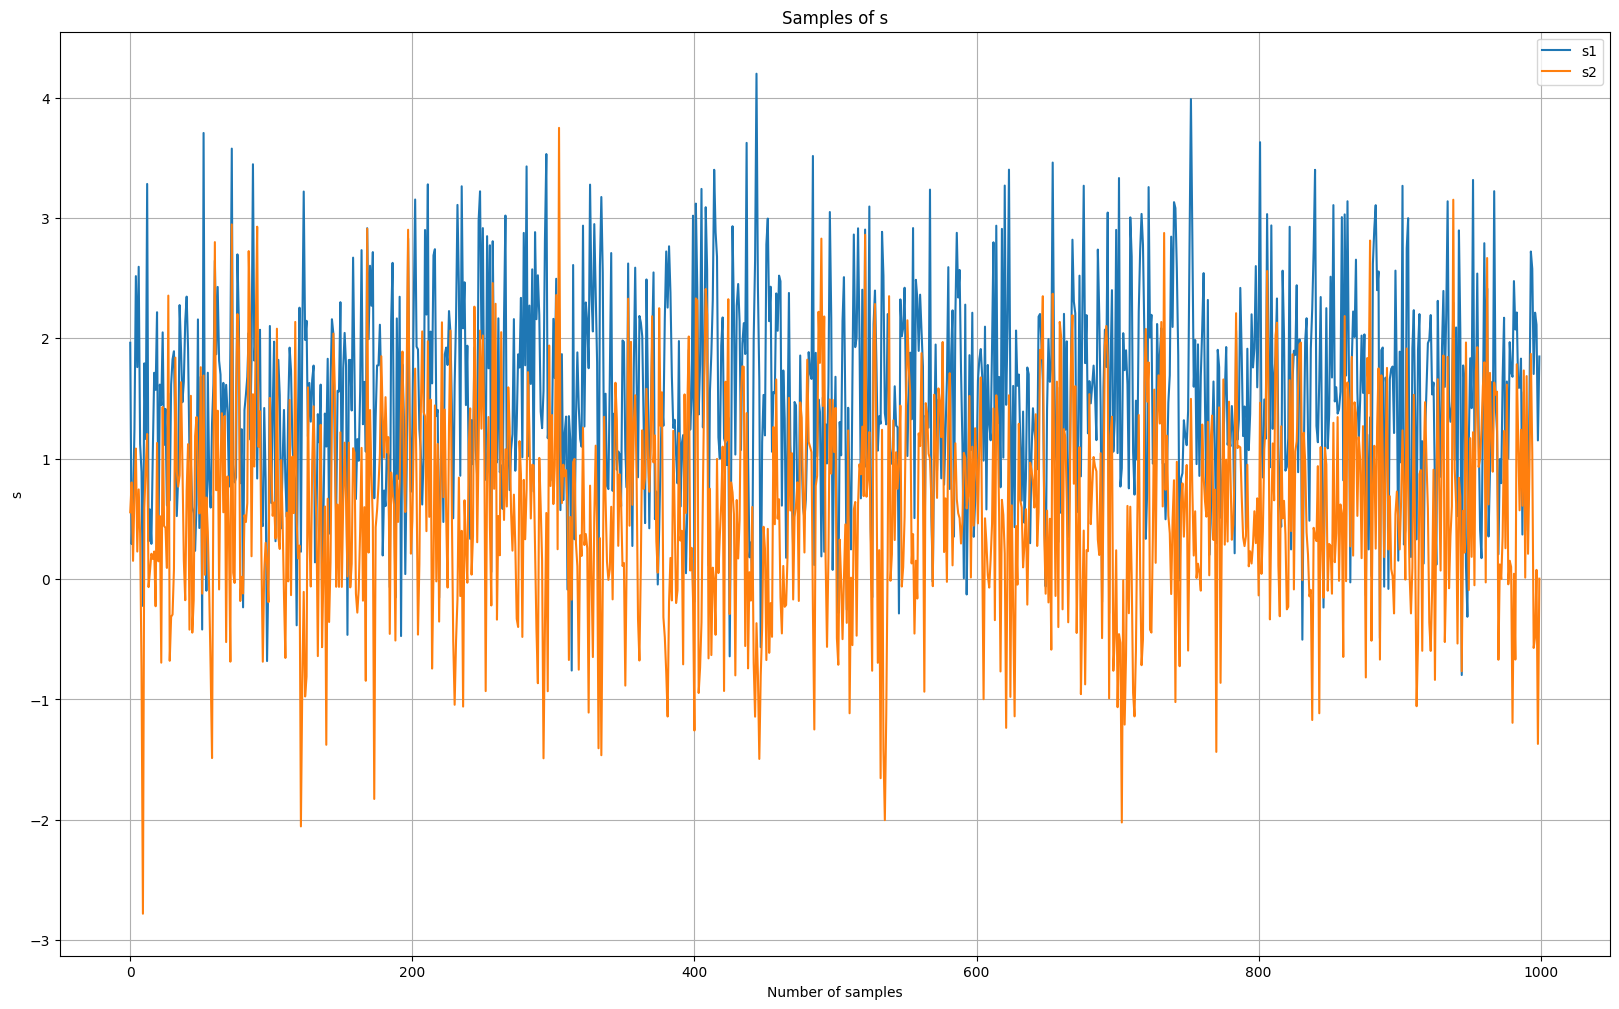

In [26]:
s0 = [0, 0]
num_samples = 1000
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])

burn = 0
vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)

plt.figure()
plt.rcParams["figure.figsize"] = (20,12)
plt.grid()
plt.plot(vec_s1)
plt.plot(vec_s2)
plt.xlabel("Number of samples")
plt.ylabel("s")
plt.title("Samples of s")
print(np.mean(vec_s1))
print(np.mean(vec_s2))
plt.legend(['s1', 's2'], loc='upper right')


### 4.2.1 re-run experiment with chosen burn-in

1.4831563106019465
0.541326501677017


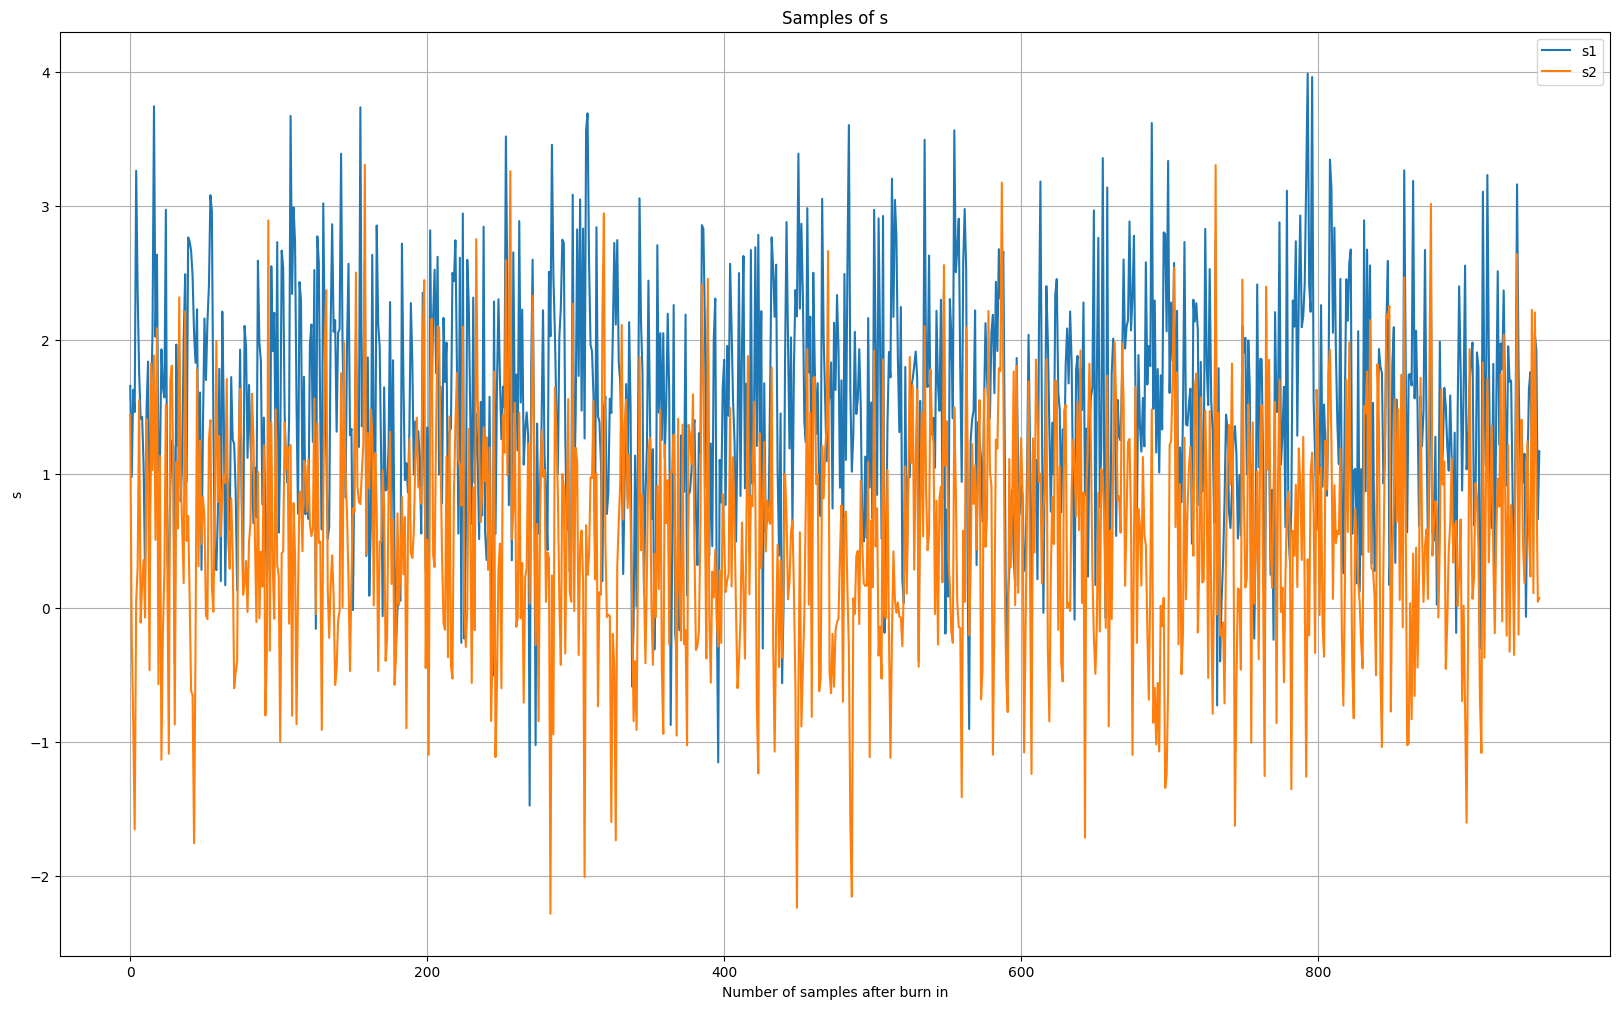

In [27]:
burn = 50
s0 = [0, 0]
num_samples = 1000
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])

burn_vec_s1, burn_vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)

plt.grid()
plt.plot(burn_vec_s1)
plt.plot(burn_vec_s2)
plt.xlabel("Number of samples after burn in")
plt.ylabel("s")
plt.title("Samples of s")
print(np.mean(burn_vec_s1))
print(np.mean(burn_vec_s2))
plt.legend(['s1', 's2'], loc='upper right')

## 4.3 & 4.4 Trueskill representation of skills as Gaussian & Compare wiht prior

In [10]:
def cvrt_gaussian(burn_vec_s1, burn_vec_s2, num_samples, burn):
    mean_s1 = np.mean(burn_vec_s1)
    std_s1 = np.std(burn_vec_s1)
    mean_s2 = np.mean(burn_vec_s2)
    std_s2 = np.std(burn_vec_s2)
    x = np.linspace(1 - 1 * 3, 1 + 1 * 3, num_samples - burn)
    y_s1 = stats.norm(loc=mean_s1, scale=std_s1).pdf(x)
    y_s2 = stats.norm(loc=mean_s2, scale=std_s2).pdf(x)
    
    plt.plot(x, y_s1, label="s1 posterior")
    plt.plot(x, y_s2, label="s2 posterior")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.hist(burn_vec_s1, bins=50, density=True, fc='lightblue')
    plt.hist(burn_vec_s2, bins=50, density=True, fc='orange')
    plt.plot(x, stats.norm.pdf(x, loc=1, scale=1), '--', label="prior")
    plt.grid()
    # time required to draw the samples
    t = int((time.time() - t0) * 1000)
    plt.title("number_samples=" + str(num_samples) + "," + "(" + str(t) + " ms)", fontsize=8)
    
    

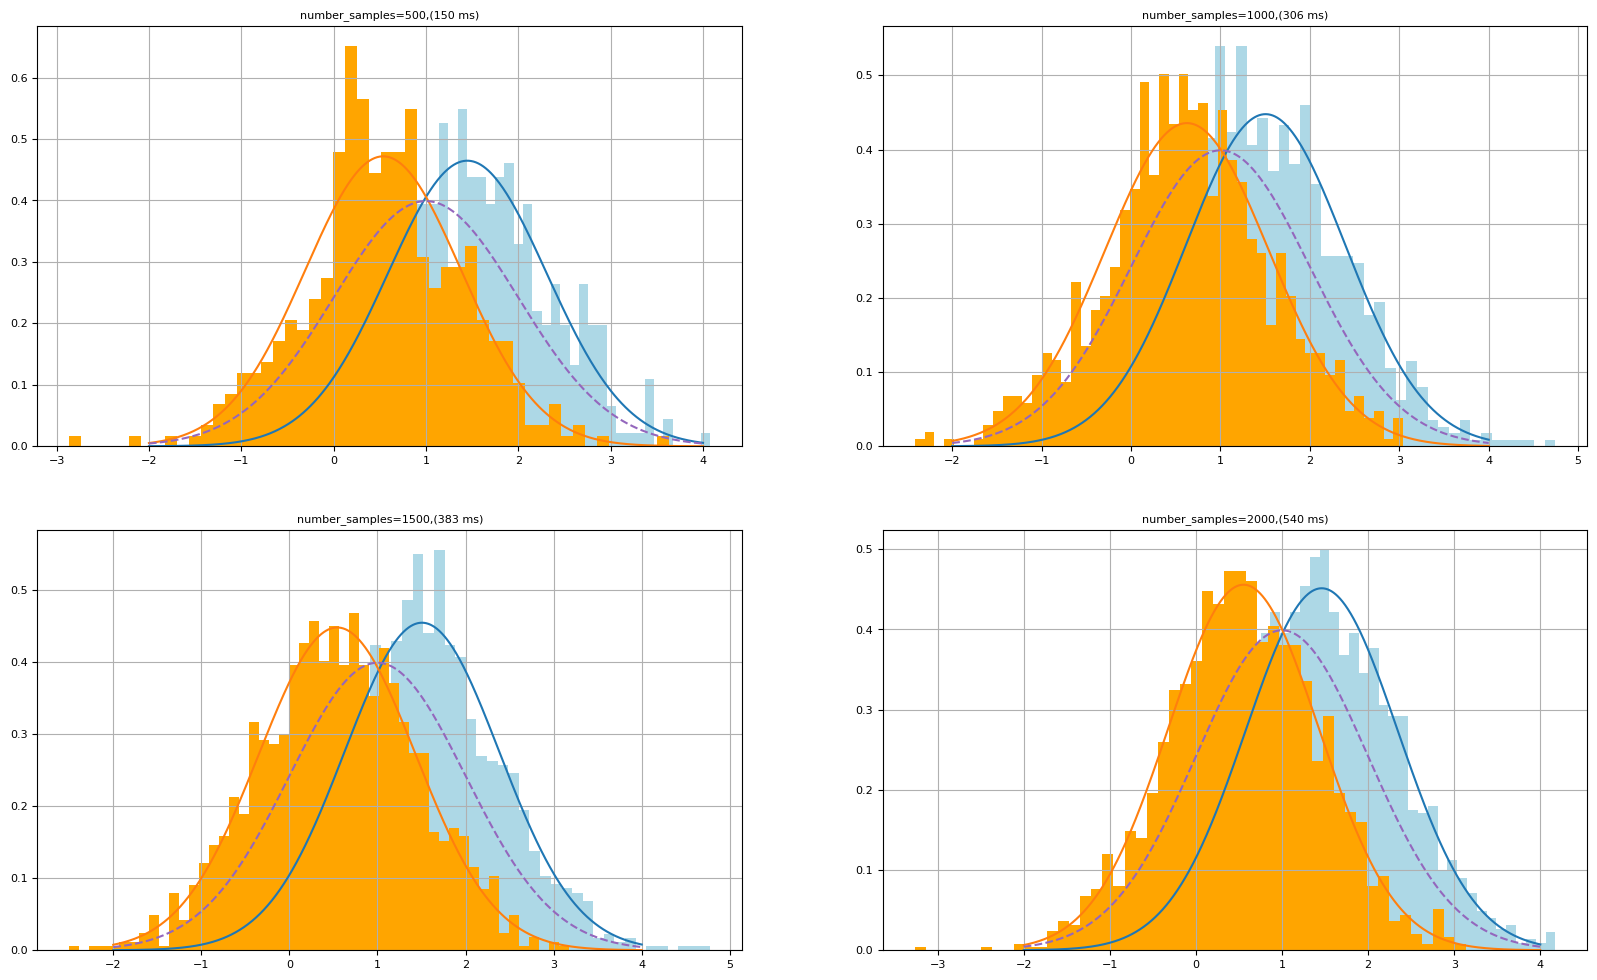

In [11]:
num_samples = 1000
burn = 50
s0 = [0, 0]
num_samples = 1000
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])

plt.rcParams["figure.figsize"] = (20,12)
plt.subplot(2,2,1)
num_samples = 500
t0 = time.time() 
burn_vec1_s1, burn_vec1_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
cvrt_gaussian(burn_vec1_s1, burn_vec1_s2, num_samples, burn)

plt.subplot(2,2,2)
num_samples = 1000
t0 = time.time() 
burn_vec2_s1, burn_vec2_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
cvrt_gaussian(burn_vec2_s1, burn_vec2_s2, num_samples, burn)

plt.subplot(2,2,3)
num_samples = 1500
t0 = time.time() 
burn_vec3_s1, burn_vec3_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
cvrt_gaussian(burn_vec3_s1, burn_vec3_s2, num_samples, burn)

plt.subplot(2,2,4)
num_samples = 2000
t0 = time.time() 
burn_vec4_s1, burn_vec4_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
cvrt_gaussian(burn_vec4_s1, burn_vec4_s2, num_samples, burn)



# 5. Assumed Density Filtering

In [32]:
df = pd.read_csv ('SerieA.csv')
cols = ['team1', 'team2', 'score1', 'score2']
df = df[cols]
df.head()

,team1,team2,score1,score2
0,Chievo,Juventus,2,3
1,Lazio,Napoli,1,2
2,Torino,Roma,0,1
3,Sassuolo,Inter,1,0
4,Parma,Udinese,2,2


In [33]:
team1 = set(df['team1'])
team2 = set(df['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))


In [34]:
s0 = [0,0]
num_samples = 1000
sigma_O = np.array([1])
burn = 50
y = 1

def ADF(df, team_dict):
    for i in range(len(df)):
        team1 = df.iloc[i,0] 
        team2 = df.iloc[i,1]
        score1 = df.iloc[i,2] 
        score2 = df.iloc[i,3]
        
        if score1 > score2:
            prior1 = skill_list[team_dict[team1]]
            prior2 = skill_list[team_dict[team2]]
            
            mu_s = np.array([[prior1[0], prior2[0]]]).T
            sigma_s = np.array([[prior1[1],0],[0,prior2[1]]])
            
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            
            posterior1 = [np.mean(vec_s1), np.var(vec_s1)]
            posterior2 = [np.mean(vec_s2), np.var(vec_s2)]
            
        else:
            prior1 = skill_list[team_dict[team2]]
            prior2 = skill_list[team_dict[team1]]
            
            mu_s = np.array([[prior1[0], prior2[0]]]).T
            sigma_s = np.array([[prior1[1],0],[0,prior2[1]]])
            
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            
            posterior2 = [np.mean(vec_s1), np.var(vec_s1)]
            posterior1 = [np.mean(vec_s2), np.var(vec_s2)]
    
        skill_list[team_dict[team1]] = posterior1
        skill_list[team_dict[team2]] = posterior2
    return skill_list



## 5.1 final ranking

In [35]:
skill_list = ADF(df, team_dict)
team_list = dict(zip(teams, skill_list))
rank_list = pd.DataFrame.from_dict(team_list, orient='index', columns=['mean', 'var'])

rank_list.sort_values(by='mean', inplace=True, ascending = False)
rank_list['Rank'] = range(1, len(rank_list) + 1)

display(rank_list)


,mean,var,Rank
Juventus,1.974026,0.053944,1
Torino,1.817804,0.050080,2
Napoli,1.588347,0.056420,3
Milan,1.544789,0.058040,4
Atalanta,1.460297,0.053437,5
Inter,1.403475,0.050428,6
Roma,1.395993,0.049273,7
Sampdoria,1.221448,0.043531,8
Lazio,1.009116,0.075034,9
Bologna,0.859866,0.045571,10


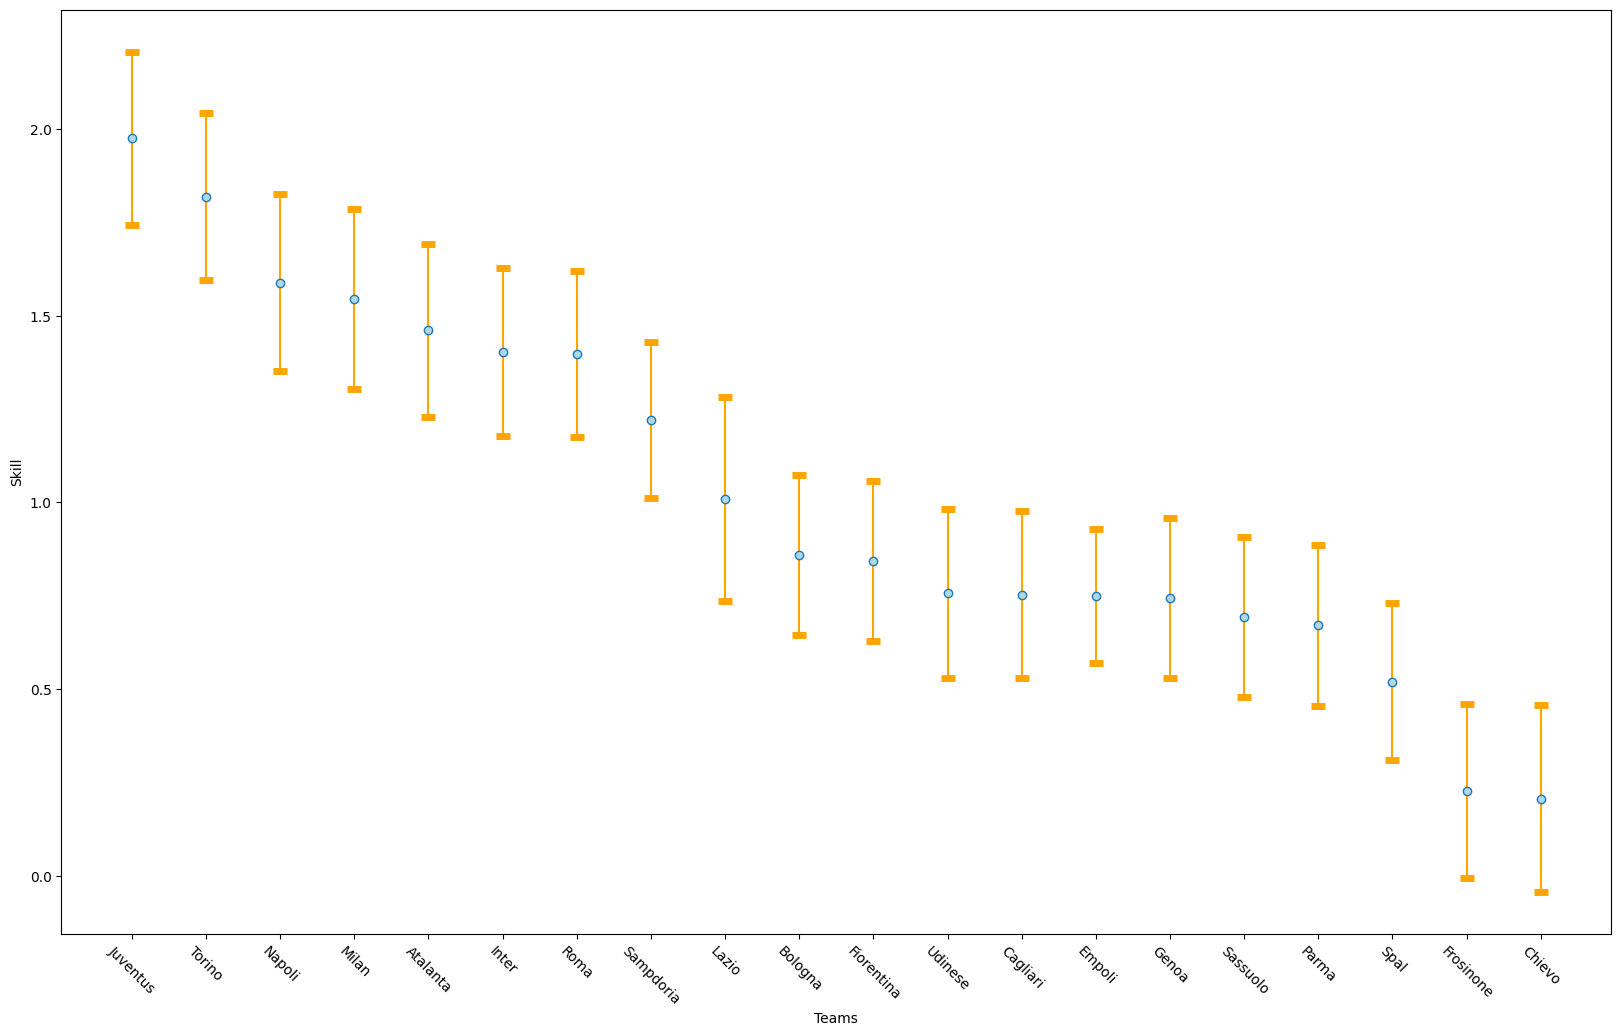

In [36]:
plt.rcParams["figure.figsize"] = (20,12)
eb = plt.errorbar(rank_list.index, rank_list['mean'], yerr=np.sqrt(rank_list['var']),
                  fmt='o', markerfacecolor='lightblue', ecolor='orange', capsize=5, capthick=5)

plt.xticks(rotation=-45)
plt.xlabel('Teams')
plt.ylabel('Skill')

plt.show()

## 5.2 Change order and re-run

In [37]:
shuffled_df = df.sample(frac = 1)
shuffled_df

,team1,team2,score1,score2
181,Udinese,Cagliari,2,0
338,Atalanta,Udinese,2,0
125,Empoli,Atalanta,3,2
176,Torino,Empoli,3,0
237,Inter,Sampdoria,2,1
...,...,...,...,...
299,Parma,Torino,0,0
131,Fiorentina,Juventus,0,3
253,Torino,Chievo,3,0
45,Chievo,Udinese,0,2


In [38]:
team1 = set(shuffled_df['team1'])
team2 = set(shuffled_df['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))

s0 = [0,0]
num_samples = 1000
sigma_O = np.array([1])
burn = 50

skill_list = ADF(shuffled_df, team_dict)

In [39]:
team_list = dict(zip(teams, skill_list))
rank_list = pd.DataFrame.from_dict(team_list, orient='index', columns=['mean', 'var'])

rank_list.sort_values(by='mean', inplace=True, ascending = False)
rank_list['Rank'] = range(1, len(rank_list) + 1)

display(rank_list)

,mean,var,Rank
Juventus,1.949164,0.049147,1
Torino,1.904036,0.058243,2
Napoli,1.722595,0.040653,3
Roma,1.642179,0.048037,4
Milan,1.584182,0.044248,5
Atalanta,1.433728,0.052546,6
Inter,1.417802,0.037925,7
Sampdoria,1.135131,0.044947,8
Lazio,1.095210,0.039774,9
Bologna,0.953989,0.051815,10


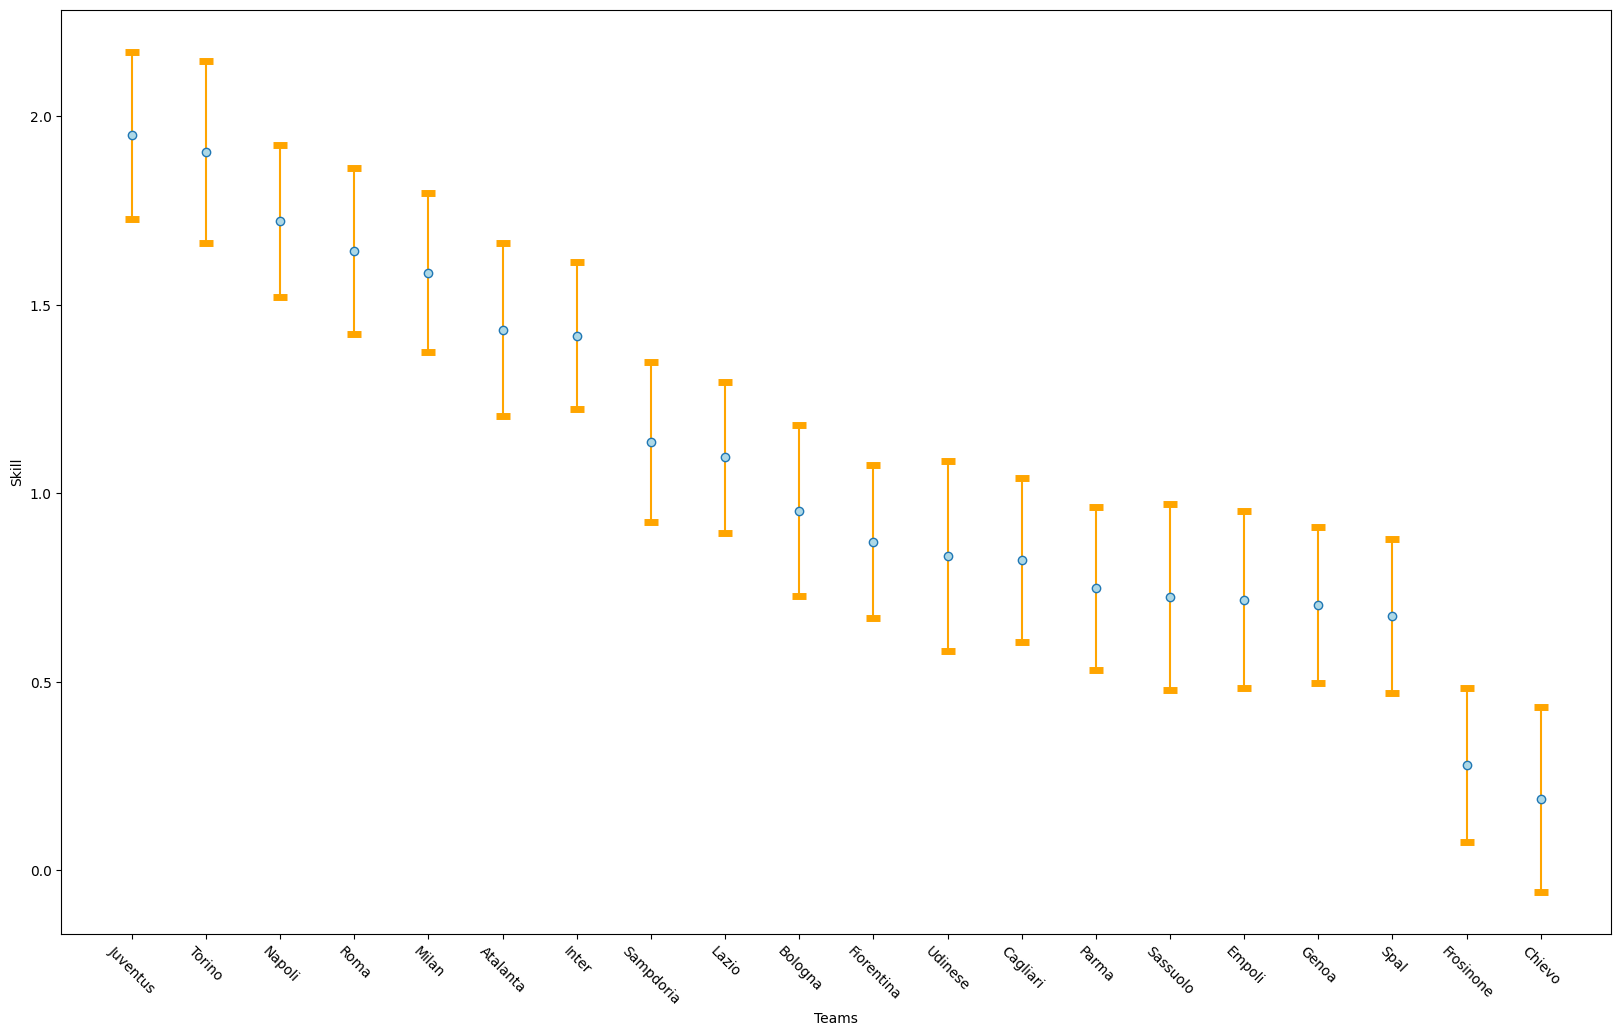

In [40]:
plt.rcParams["figure.figsize"] = (20,12)
eb = plt.errorbar(rank_list.index, rank_list['mean'], yerr=np.sqrt(rank_list['var']),
                  fmt='o', markerfacecolor='lightblue', ecolor='orange', capsize=5, capthick=5)

plt.xticks(rotation=-45)
plt.xlabel('Teams')
plt.ylabel('Skill')

plt.show()

# 6. Using the model for predictions

In [41]:
predictions_df = df
predictions_df["prediction"] = 0
predictions_df['result'] = predictions_df.apply(lambda row: 1 if row.score1 > row.score2 else -1, axis=1)
predictions_df

,team1,team2,score1,score2,prediction,result
0,Chievo,Juventus,2,3,0,-1
1,Lazio,Napoli,1,2,0,-1
2,Torino,Roma,0,1,0,-1
3,Sassuolo,Inter,1,0,0,1
4,Parma,Udinese,2,2,0,-1
...,...,...,...,...,...,...
375,Roma,Parma,2,1,0,1
376,Inter,Empoli,2,1,0,1
377,Fiorentina,Genoa,0,0,0,-1
378,Cagliari,Udinese,1,2,0,-1


In [42]:
team1 = set(predictions_df['team1'])
team2 = set(predictions_df['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))

def predict_y(s1, s2):
    if s1 > s2:
        return 1
    return -1

def predictions(skill_list, data):
    for i, row in data.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        score1 = row['score1']
        score2 = row['score2']
        mu1 = skill_list[team_dict[team1]]
        mu2 = skill_list[team_dict[team2]]
        mu_s = np.array([[mu1[0], mu2[0]]]).T
        sigma_s = np.array([[mu1[1],0],[0,mu2[1]]])
        
        if score1 > score2:
            y = 1
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            s1 = [np.mean(vec_s1), np.var(vec_s1)]
            s2 = [np.mean(vec_s2), np.var(vec_s2)]
            skill_list[team_dict[team1]] = s1
            skill_list[team_dict[team2]] = s2
            data.at[i, 'prediction'] = predict_y(s1, s2)

        else:
            y = -1
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            s1 = [np.mean(vec_s1), np.var(vec_s1)]
            s2 = [np.mean(vec_s2), np.var(vec_s2)]
            skill_list[team_dict[team1]] = s1
            skill_list[team_dict[team2]] = s2
            data.at[i, 'prediction'] = predict_y(s1, s2)
    return data


In [43]:
predictions_df = predictions(skill_list, predictions_df)
correct_predictions = predictions_df[predictions_df['prediction'] == predictions_df['result']]
len(correct_predictions)/len(predictions_df)

0.7605263157894737

# 8. A message-passing algorithm

In [336]:
def multiplyGauss(mean1, var1, mean2, var2):
    s = 1/(1/var1 + 1/var2)
    m = (mean1/var1 + mean2/var2) * s
    return m, s

def divideGauss(mean1, var1, mean2, var2):
    return multiplyGauss(mean1, var1, mean2, -var2)

def truncGaussMM(a, b, mean, var):
    return stats.truncnorm.mean(a, b, loc=mean, scale=np.sqrt(var)), stats.truncnorm.var(a, b, loc=mean, scale=np.sqrt(var))

def MM(y, message_m, message_s):
    if y == 1:
        a, b = (0 - message_m)/np.sqrt(message_s), np.inf  
    else:
        a, b = -np.inf, (0 - message_m)/np.sqrt(message_s)
    return truncGaussMM(a, b, message_m, message_s)


In [337]:
def message_pass(mean1, mean2, var1, var2, var_t):
    mean_ms1 = mean1
    var_ms1 = var1

    mean_ms2 = mean2
    var_ms2 = var2
    
    mean_s1s2 = mean_ms1 - mean_ms2
    var_s1s2 = var_ms1 + var_ms2 + var_t

    pt_m, pt_s = MM(y, mean_s1s2, var_s1s2)

    mean_pt, var_pt = divideGauss(pt_m, pt_s, mean_s1s2, var_s1s2)
        
    mean_s1s2t, var_s1s2t = mean_pt + mean_ms2, var_t + var_pt + var_ms2
    posts1_m, posts1_s = multiplyGauss(mean_s1s2t, var_s1s2t, mean_ms1, var_ms1)
        
    mean_s1s2t2, var_s1s2t2 = mean_ms1 - mean_pt, var_t + var_pt + var_ms1
    posts2_m, posts2_s = multiplyGauss(mean_s1s2t2, var_s1s2t2, mean_ms2, var_ms2)

    return posts1_m, posts1_s, posts2_m, posts2_s

In [338]:
mean1 = 1
mean2 = 1
var1 = 1
var2 = 1
var_t = 1

s0 = [0,0]
num_samples = 2000
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])
burn = 50

xv = np.linspace(1 - 1 * 3, 1 + 1 * 3, num_samples - burn)

posts1_m, posts1_s, posts2_m, posts2_s = message_pass(mean1, mean2, var1, var2, var_t)
vec1 = stats.norm.pdf(xv, loc=posts1_m, scale=np.sqrt(posts1_s))
vec2 = stats.norm.pdf(xv, loc=posts2_m, scale=np.sqrt(posts2_s))


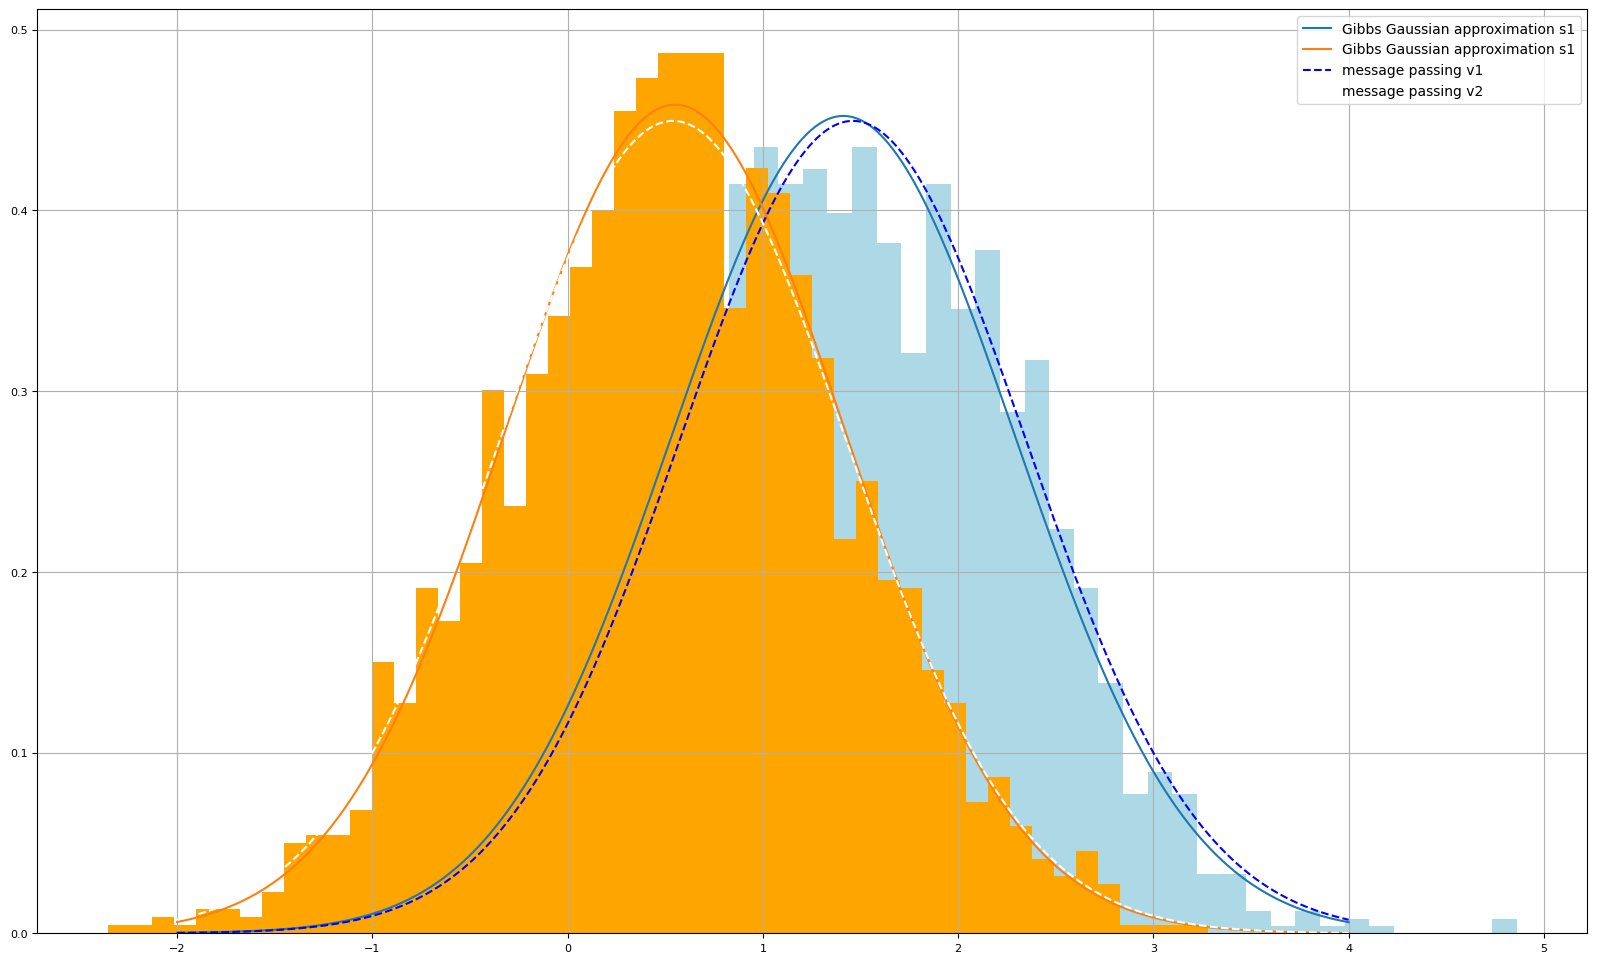

In [339]:
burn_vec_s1, burn_vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)

def gaussian(burn_vec_s1, burn_vec_s2, num_samples, burn):
    mean_s1 = np.mean(burn_vec_s1)
    std_s1 = np.std(burn_vec_s1)
    mean_s2 = np.mean(burn_vec_s2)
    std_s2 = np.std(burn_vec_s2)
    x = np.linspace(1 - 1 * 3, 1 + 1 * 3, num_samples - burn)
    y_s1 = stats.norm.pdf(x, loc=mean_s1, scale=std_s1)
    y_s2 = stats.norm.pdf(x, loc=mean_s2, scale=std_s2)
    return y_s1, y_s2

y_s1, y_s2 = gaussian(burn_vec_s1, burn_vec_s2, num_samples, burn)

plt.plot(xv, y_s1, label="Gibbs Gaussian approximation s1")
plt.plot(xv, y_s2, label="Gibbs Gaussian approximation s1")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.hist(burn_vec_s1, bins=50, density=True, fc='lightblue')
plt.hist(burn_vec_s2, bins=50, density=True, fc='orange')
plt.grid()
plt.plot(xv, vec1, 'b--', label="message passing v1")
plt.plot(xv, vec2, 'w--', label="message passing v2")
plt.legend(loc="best")
plt.show()

# 9. Your own data

In [328]:
import pandas as pd
data = pd.read_csv ('games_2010s.csv')
cols = ['team1', 'team2', 'score1', 'score2']
data = data[cols]
data.head()

,team1,team2,score1,score2
0,Phoenix Suns,Utah Jazz,106,95
1,Philadelphia 76ers,Orlando Magic,116,92
2,New Orleans Pelicans,Oklahoma City Thunder,113,80
3,Oklahoma City Thunder,New Orleans Pelicans,80,113
4,Sacramento Kings,Houston Rockets,119,122


In [329]:
team1 = set(data['team1'])
team2 = set(data['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))


## 9.1 ADF

In [330]:
skill_list = ADF(data, team_dict)

## 9.2 Ranking

In [331]:
team_list = dict(zip(teams, skill_list))
rank_list = pd.DataFrame.from_dict(team_list, orient='index', columns=['mean', 'var'])

rank_list.sort_values(by='mean', inplace=True, ascending = False)
rank_list['Rank'] = range(1, len(rank_list) + 1)

display(rank_list)

,mean,var,Rank
Los Angeles Lakers,1.310596,0.008156,1
Toronto Raptors,1.304629,0.022218,2
Miami Heat,1.164506,0.019020,3
Los Angeles Clippers,1.161857,0.021860,4
Boston Celtics,1.120807,0.013285,5
Indiana Pacers,1.115052,0.018030,6
Sacramento Kings,1.026813,0.024451,7
Milwaukee Bucks,1.004266,0.016338,8
Portland Trail Blazers,1.003887,0.031690,9
Oklahoma City Thunder,0.966420,0.023266,10


## 9.3 Prediction rate

In [332]:
predictions_df = data
predictions_df["prediction"] = 0
predictions_df['result'] = predictions_df.apply(lambda row: 1 if row.score1 > row.score2 else -1, axis=1)

team1 = set(predictions_df['team1'])
team2 = set(predictions_df['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))

predictions_data = predictions(skill_list, predictions_df)

In [333]:
correct_predictions = predictions_data[predictions_data['prediction'] == predictions_data['result']]
len(correct_predictions)/len(predictions_data)

0.687374749498998

# 10. Open-ended project extension
consider draws

In [44]:
data2 = pd.read_csv ('SerieA.csv')
cols = ['team1', 'team2', 'score1', 'score2']
data2 = data2[cols]
data2['prediction'] = 0

result = []
for i, row in data2.iterrows():
    if row['score1'] > row['score2']:
        result.append(1)
    elif row['score1'] < row['score2']:
        result.append(-1)
    else:
        result.append(0)
data2['result'] = result
data2

,team1,team2,score1,score2,prediction,result
0,Chievo,Juventus,2,3,0,-1
1,Lazio,Napoli,1,2,0,-1
2,Torino,Roma,0,1,0,-1
3,Sassuolo,Inter,1,0,0,1
4,Parma,Udinese,2,2,0,0
...,...,...,...,...,...,...
375,Roma,Parma,2,1,0,1
376,Inter,Empoli,2,1,0,1
377,Fiorentina,Genoa,0,0,0,0
378,Cagliari,Udinese,1,2,0,-1


In [45]:
import scipy

team1 = set(data2['team1'])
team2 = set(data2['team2'])
teams = team1.union(team2)
team_dict = dict(zip(teams, range(len(teams))))
skill_list = np.ones((len(teams), 2))

draw_prob = 0.5
s0 = [0,0]
num_samples = 2000
y = 1
mu_s = np.array([[1, 1]]).T
sigma_s = np.array([[1,0],[0,1]])
sigma_O = np.array([1])
burn = 50

def newpredict_y(s1, s2):
    beta = ((s1[1] + s2[1])/4)**2
    margin = np.abs(s1[0] - s2[0])
    epsilon = scipy.stats.norm.ppf((draw_prob + 1)/2)*np.sqrt(2)*beta

    if(margin < epsilon):
      return 0

    y1, y2 = s1[0] - 3*s1[1], s2[0] - 3*s2[1]
    if(y1 >= y2):
      return 1
    else:
      return -1

def predictions(skill_list, data):
    for i, row in data.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        score1 = row['score1']
        score2 = row['score2']
        mu1 = skill_list[team_dict[team1]]
        mu2 = skill_list[team_dict[team2]]
        mu_s = np.array([[mu1[0], mu2[0]]]).T
        sigma_s = np.array([[mu1[1],0],[0,mu2[1]]])
        
        if score1 > score2:
            y = 1
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            s1 = [np.mean(vec_s1), np.var(vec_s1)]
            s2 = [np.mean(vec_s2), np.var(vec_s2)]
            skill_list[team_dict[team1]] = s1
            skill_list[team_dict[team2]] = s2
            data.at[i, 'prediction'] = newpredict_y(s1, s2)

        elif score1 < score2:
            y = -1
            vec_s1, vec_s2 = GibbsSampling(s0, y, mu_s, sigma_s, sigma_O, num_samples, burn)
            s1 = [np.mean(vec_s1), np.var(vec_s1)]
            s2 = [np.mean(vec_s2), np.var(vec_s2)]
            skill_list[team_dict[team1]] = s1
            skill_list[team_dict[team2]] = s2
            data.at[i, 'prediction'] = newpredict_y(s1, s2)
        else:
            data.at[i, 'prediction'] = 0
    return data

In [46]:
pre_df = predictions(skill_list, data2)
correct_predictions = pre_df[pre_df['prediction'] == pre_df['result']]
len(correct_predictions)/len(pre_df)

0.8578947368421053

## 10.1 Conclusion about the improved algorithm
So we can see the improved prediction algorithm has a prediction rate of 0.858 while the previous is 0.761.